# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [2]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [3]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

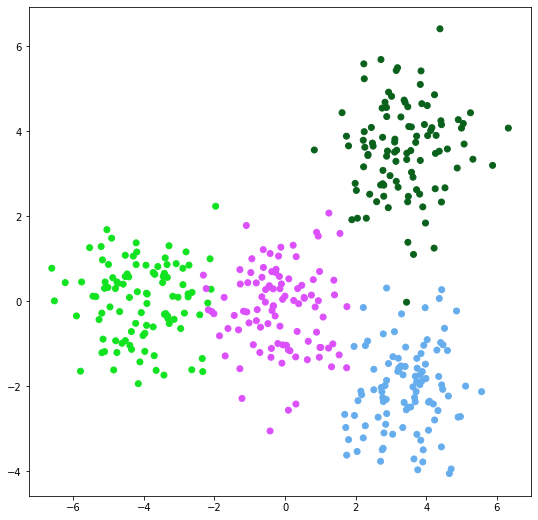

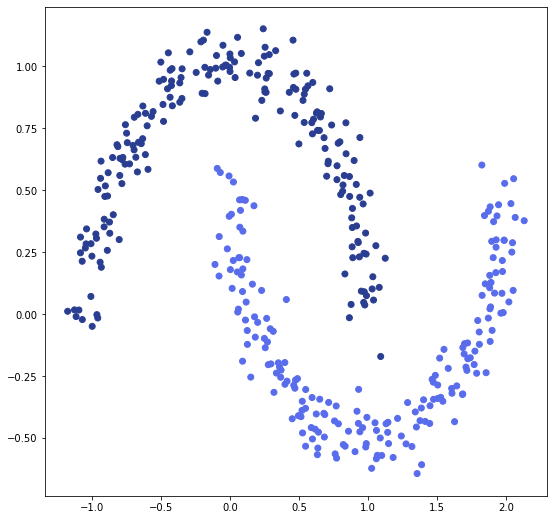

In [4]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [31]:
class KMeans:
    
    centers = None
    init = None
    max_iter = None
    n_clusters = None
    dimension = None
    
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        
        
    def calculate_dist(self, a, b):
        return np.sqrt(((a - b) ** 2).sum())
        
    def calculate_dist_square(self, a, b):
        return ((a - b) ** 2).sum()
        
    
    def calculate_center(self, arr):
        ans = np.array([0.0] * self.dimension)
        for a in arr:
            ans = ans + np.array(a)
        return ans / (np.array([len(arr)] * self.dimension))
        
        
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        self.dimension = len(X[0])
        high  = X.max().max()
        low = X.min().min()
        if self.init == 'random':
            print(high)
            self.centers = (np.random.randint(low=low, high=high, size=(self.n_clusters, self.dimension)))
        elif self.init == 'sample':
            self.centers = random.sample(X.tolist(), self.n_clusters)
        else:
            self.centers = [random.sample(range(int(low - 1), int(high + 1)), self.dimension)]
            while len(self.centers) < self.n_clusters:
                sum_d = 0
                for point in X:
                    min_dist = -1 
                    
                    for cnt in self.centers:
                        if min_dist == -1 or min_dist > self.calculate_dist_square(point, cnt):
                            min_dist = self.calculate_dist_square(point, cnt)
                    
                    sum_d += min_dist
                
                rnd = random.uniform(0, 1) * sum_d
                
                
                sum_d = 0
                for point in X:
                    min_dist = -1 
                    
                    for cnt in self.centers:
                        if min_dist == -1 or min_dist > self.calculate_dist_square(point, cnt):
                            min_dist = self.calculate_dist_square(point, cnt)
                    
                    sum_d += min_dist
                    if sum_d > rnd:
                        self.centers.append(point.tolist())
                        break
    
        
        for i in range(0, self.max_iter):
            center_to_points = [[]] * len(self.centers)
            for point in X:
                mean_center = None
                min_dist = -1
                for index, cnt in enumerate(self.centers):
                    if min_dist == -1 or min_dist > self.calculate_dist(point, cnt):
                        min_dist = self.calculate_dist(point, cnt)
                        mean_center = index
                
                center_to_points[mean_center] = center_to_points[mean_center] + [point.tolist()]
    
            for j in range(0, len(self.centers)):
                self.centers[j] = self.calculate_center(center_to_points[j])
    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        ans = []
        for point in X:
            mean_center = None
            min_dist = -1
            for index, cnt in enumerate(self.centers):
                if min_dist == -1 or min_dist > self.calculate_dist(point, cnt):
                    min_dist = self.calculate_dist(point, cnt)
                    mean_center = index
            ans.append(mean_center)
                
        return ans
            
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

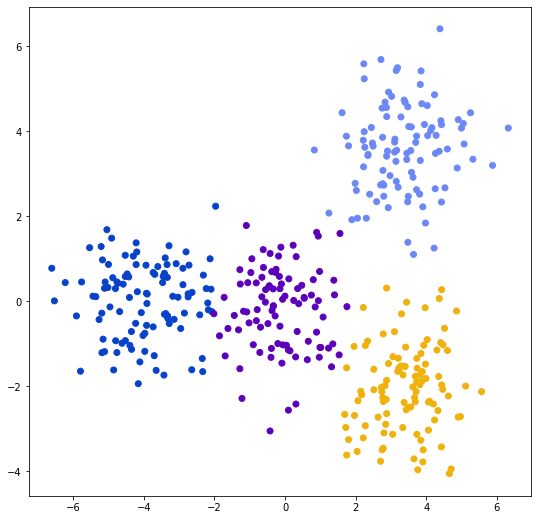

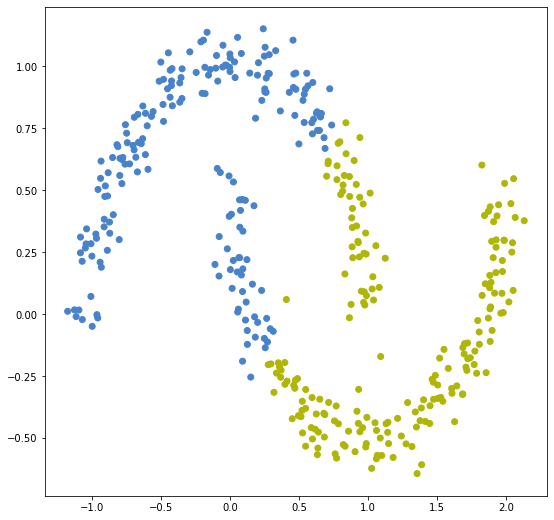

In [6]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [7]:
class DBScan:
    eps = None
    min_samples = None
    leaf_size = None
    metric = None
    tree = None
    
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        self.tree = KDTree(X, self.leaf_size, metric=self.metric)        
        
        label = [-1] * len(X)
    
        C = 0
        
        for _id, point in enumerate(X):
            
            if label[_id] != -1:
                continue
                
            [ind] = self.tree.query_radius([point], r=self.eps)
            
            if len(ind) < self.min_samples:
                label[_id] = 0
                continue
                    
            C += 1
            label[_id] = C
            k = 0
            while k < len(ind):
                i = ind[k]
                k += 1
                if label[i] == 0:
                    label[i] = C
                if label[i] != -1:
                    continue
                label[i] = C
                
                [ind1] = self.tree.query_radius([X[i]], r=self.eps)
                if len(ind1) >= self.min_samples:
                    ind = list(ind) + list(set(ind1) - set(ind))
        
        return np.array(label) - np.array([min(label)] * len(label))



Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

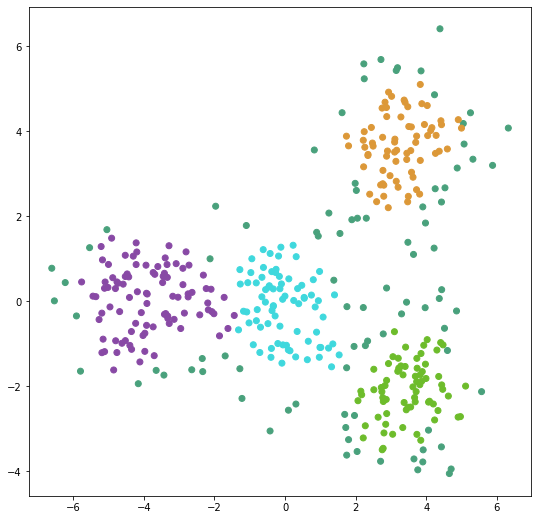

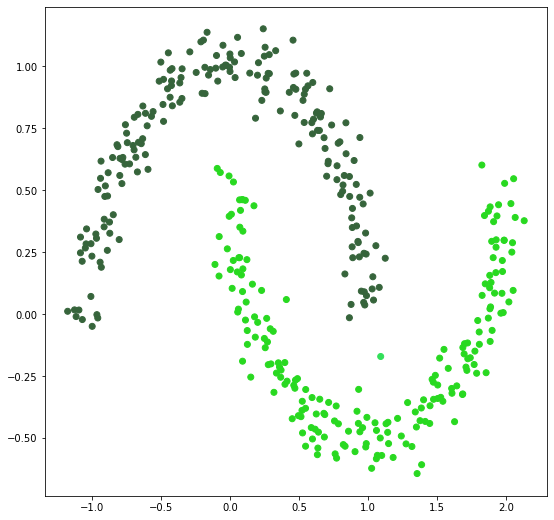

In [97]:
dbscan = DBScan(eps=0.6, min_samples=10)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [9]:
class AgglomertiveClustering:
    n_clusters = None
    linkage = None
    clusters = None
    
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage
        
    def calculate_dist_point(self, p1, p2):
        return np.sqrt(((p1 - p2) ** 2).sum())
    
    def calculate_dist(self, cl1, cl2):
        if self.linkage == 'average':
            s = 0
            for i in cl1:
                for j in cl2:
                    s += self.calculate_dist_point(i, j)
            return s / (len(cl1) * len(cl2))
        elif self.linkage == 'single':
            s = -1
            for i in cl1:
                for j in cl2:
                    if  s == -1 or s > self.calculate_dist_point(i, j):
                        s = self.calculate_dist_point(i, j)
            return s
        else:
            s = -1
            for i in cl1:
                for j in cl2:
                    if  s == -1 or s < self.calculate_dist_point(i, j):
                        s = self.calculate_dist_point(i, j)
            return s
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        hash_map = dict()
        for i, p in enumerate(X):
            hash_map[str(p)] = i
        
        
        self.clusters = []
        for i in X:
            self.clusters.append([i])
            
        while len(self.clusters) != self.n_clusters:
            min_i = -1
            min_j = -1
            min_dist = -1
            for i, cl1 in enumerate(self.clusters):
                for j, cl2 in enumerate(self.clusters):
                    if i == j:
                        continue
                        
                    if min_dist == -1 or min_dist > self.calculate_dist(cl1, cl2):
                        min_i = i
                        min_j = j
                        min_dist = self.calculate_dist(cl1, cl2)
            
            i = min(min_i, min_j)
            j = max(min_i, min_j)
            
            cl1 = self.clusters.pop(j)
            cl2 = self.clusters.pop(i)
            self.clusters.append(cl1 + cl2)
        
        ans = [0] * len(X)
        
        for i, cl in enumerate(self.clusters):
            for p in cl:
                ans[hash_map[str(p)]] = i
        return ans
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

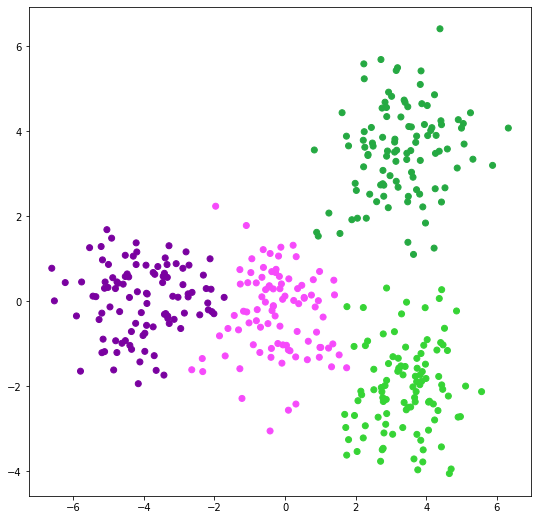

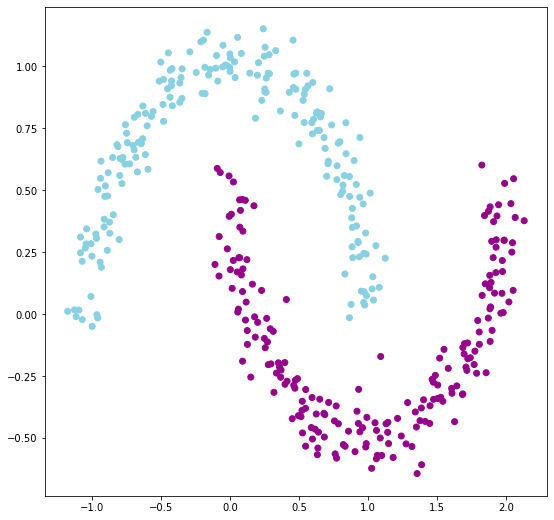

In [10]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [64]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    img = cv2.imread(path)
    for i in range(0, len(img)):
        for j in range(0, len(img[0])):
            tmp = img[i][j][0]
            img[i][j][0] = img[i][j][2]
            img[i][j][2] = tmp
            
    image = []
    
    for i in range(0, len(img)):
        tmp = []
        for j in range(0, len(img[0])):
            a = float(img[i][j][0]) / 255
            b = float(img[i][j][1]) / 255
            c = float(img[i][j][2]) / 255
            
            tmp += [np.array([a, b, c])]
            
        image += [np.array(tmp)]
    
    image = np.array(image)
    return image

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    
    img = []
    
    for i in range(0, len(image)):
        tmp = []
        for j in range(0, len(image[0])):
            a = int(float(image[i][j][0]) * 255)
            b = int(float(image[i][j][1]) * 255)
            c = int(float(image[i][j][2]) * 255)
            
            tmp += [np.array([a, b, c])]
            
        img += [np.array(tmp)]
    
    img = np.array(img)
    
    plt.figure(figsize=np.array(img.shape[:-1]) / 50)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
        
    img = []
    
    for i in range(0, len(image)):
        tmp = []
        for j in range(0, len(image[0])):
            a = int(float(image[i][j][0]) * 255)
            b = int(float(image[i][j][1]) * 255)
            c = int(float(image[i][j][2]) * 255)
            
            tmp += [np.array([a, b, c])]
            
        img += [np.array(tmp)]
    
    img = np.array(img)
    
    for i in range(0, len(img)):
        for j in range(0, len(img[0])):
            t = img[i][j][0]
            img[i][j][0] = img[i][j][2]
            img[i][j][2] = t
            
    cv2.imwrite(path, img)

In [65]:
save_image(read_image("./kek.jpg"), "pukmuk.png")

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [70]:
def clusterize_image(image, **kwargs):
    cluster_colors = None # color of each cluster
    clusters = None # Cluster labels for each pixel in flattened image
    recolored = None # Image with pixel colors assigned to corresponding cluster colors
    
    X = []
    
    n_clusters = 4
    
    for i in range(0, len(image)):
        for j in range(0, len(image[0])):
             X += [image[i][j]]
    
    X = np.array(X)
    print(X.max().max())
    
    kmeans = KMeans(n_clusters=n_clusters, init='sample')
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    
    
    cluster_colors = [[0, 0, 0]] * n_clusters
    
    for i in range(0, n_clusters):
        color = np.array([0.0, 0.0, 0.0])
        num = 0
        for j, col in enumerate(clusters):
            if col == i:
                color += X[j]
                num += 1
        print(color, "QQQ")
        color /= np.array([num, num, num])
        cluster_colors[i] = color
    
    print(cluster_colors)
    
    recolored = image
    for i in range(0, len(image)):
        for j in range(0, len(image[0])):
            recolored[i][j] = cluster_colors[clusters[i * len(image[0]) + j]]
    
    
    clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored

1.0
[8730.76470588 7084.00784314 6254.32156863] QQQ
[20748.35294117 11938.39607843 11181.21960784] QQQ
[5642.54901961 1549.72941176 3878.15686275] QQQ
[11297.17647059  4823.86666667  5820.89803922] QQQ
[array([0.90268452, 0.7324243 , 0.64664201]), array([0.83548172, 0.48072788, 0.45023837]), array([0.39450109, 0.10834996, 0.2711429 ]), array([0.67538569, 0.28838804, 0.34799414])]


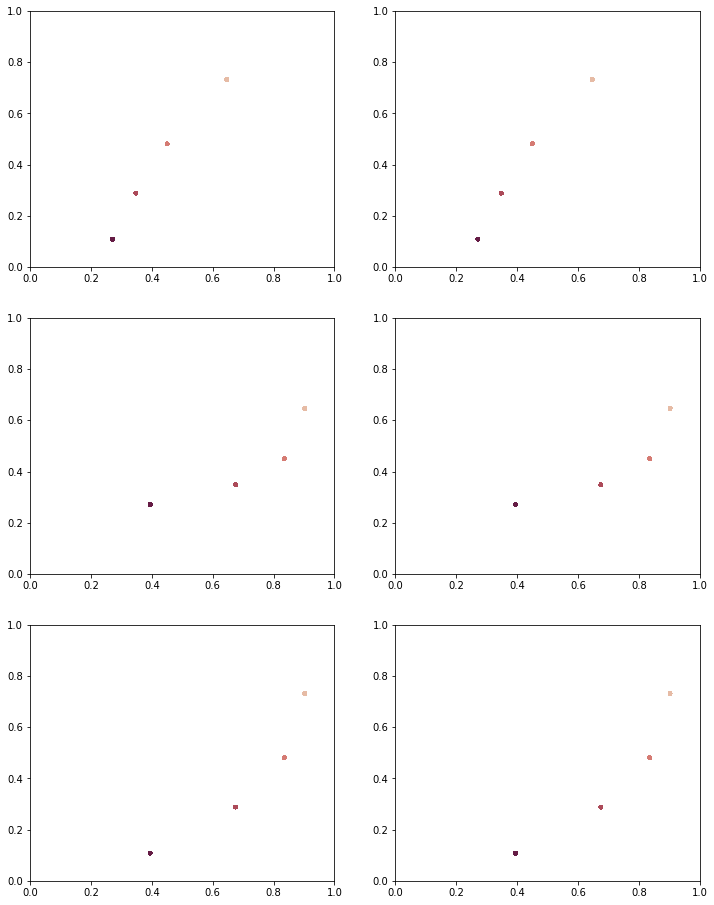

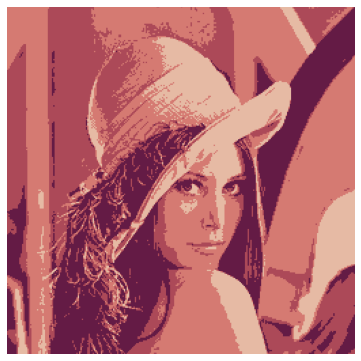

In [74]:
image = read_image("./lena.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.png")